# EVM Memory Analysis: Usage Trends

## Introduction

The EVM's memory is a *word-addressed* byte array that stores its ephemeral state. Accessing memory incurs fees in a unit called gas.

Gas does not measure the direct cost of execution, but rather the computational effort required by a node's hardware to execute EVM instructions. Transactors pay for per unit gas at market value which ultimately determines the execution cost.

The goal of this project is to provide insights that could potentially lead to repricing memory access costs, making them more affordable. To support this analysis, the usage of memory-accessing instructions (listed in Appendix A) was first examined across **100,000 blocks (from 20,770,001 to 20,870,000)** on the Ethereum mainnet.

## Usage Trends
Intially, **3 billion (3,116,961,839)** memory-accessing instructions were recorded.  However, certain instructions, such as `CALL`, may not require input from memory or may discard their return data instead of writing to memory. In these instances, a zero-length range of memory may be referenced, which [does not trigger an expansion](https://github.com/ethereum/yellowpaper/blob/9fde3f4a07487b702a4b30ff74f26e0cd153db05/Paper.tex#L2217) and incurs no gas cost. In total, **62,086,976** such instructions (**≈2%** of all memory-accessing instructions) were identified and excluded from further analysis which brings down the total instruction count to **3,054,874,863.**

In [1]:
import vaex
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import norm

# CONFIG
PERCENTILE_RANGES = [25, 50, 75, 95, 99]
PRIMARY_COLOR = '#731963'
ACCENT_COLOR_1 = '#F0E100'
ACCENT_COLOR_2 = '#808080'

# Load data 
df = vaex.open('data/combined_call_frames.hdf5')
opcode_to_mnemonic = {"20":"KECCAK256","37":"CALLDATACOPY","39":"CODECOPY","51":"MLOAD","52":"MSTORE","53":"MSTORE8","3c":"EXTCODECOPY","3e":"RETURNDATACOPY","5e":"MCOPY","a0":"LOG0","a1":"LOG1","a2":"LOG2","a3":"LOG3","a4":"LOG4","f0":"CREATE","f1":"CALL","f2":"CALLCODE","f3":"RETURN","f4":"DELEGATECALL","f5":"CREATE2","fa":"STATICCALL"}
df["opcode"] = df["opcode"].map(opcode_to_mnemonic)
df

#,transaction_id,call_depth,opcode,memory_access_offset,memory_access_size,opcode_gas_cost,memory_expansion
0,1_3,2,MSTORE,64,32,12,96
1,1_3,2,MLOAD,64,32,3,0
2,1_3,2,MLOAD,64,32,3,0
3,1_3,2,MSTORE,128,32,9,64
4,1_3,2,MLOAD,64,32,3,0
...,...,...,...,...,...,...,...
"3,054,874,858",10_1710248,1,MLOAD,642,32,3,0
"3,054,874,859",10_1710248,1,MSTORE,834,32,3,0
"3,054,874,860",10_1710248,1,MSTORE,841,32,3,0
"3,054,874,861",10_1710248,1,MLOAD,64,32,3,0


### Memory Size

Across **100,000 blocks**, a total of **111.5 GiB** of memory was accessed (expanded or otherwise). Each instruction accesses between **1 and 460,800 bytes** of memory, with an average of **39 bytes** (slightly over 1 EVM word). In a single instance `CODECOPY` accessed the maximum memory size i.e 460,800 bytes. The `CREATE*`, `*CODECOPY`, and `*CALL` family of instructions consume the most memory on average, followed by `KECCAK256`.

In [2]:
df_summary = df.describe()

def show_column_summary(column):
    column_summary  = df_summary[[str(column)]].copy(deep=True)

    percentiles = np.percentile(column.values, PERCENTILE_RANGES)
    for i, percentile in enumerate(percentiles):
        column_summary.loc[f"{PERCENTILE_RANGES[i]} percentile"] = percentile
    return column_summary

show_column_summary(df.memory_access_size)

,memory_access_size
data_type,int64
count,3054874863
NA,0
mean,39.189048925700625
std,160.459784
min,1
max,460800
25 percentile,32.0
50 percentile,32.0
75 percentile,32.0


#### Total memory access accross all blocks

In [3]:
df.memory_access_size.sum()

array(119717640468)

#### Frequently accessed memory

Only for sizes below the 99th percentile to account for outliers.

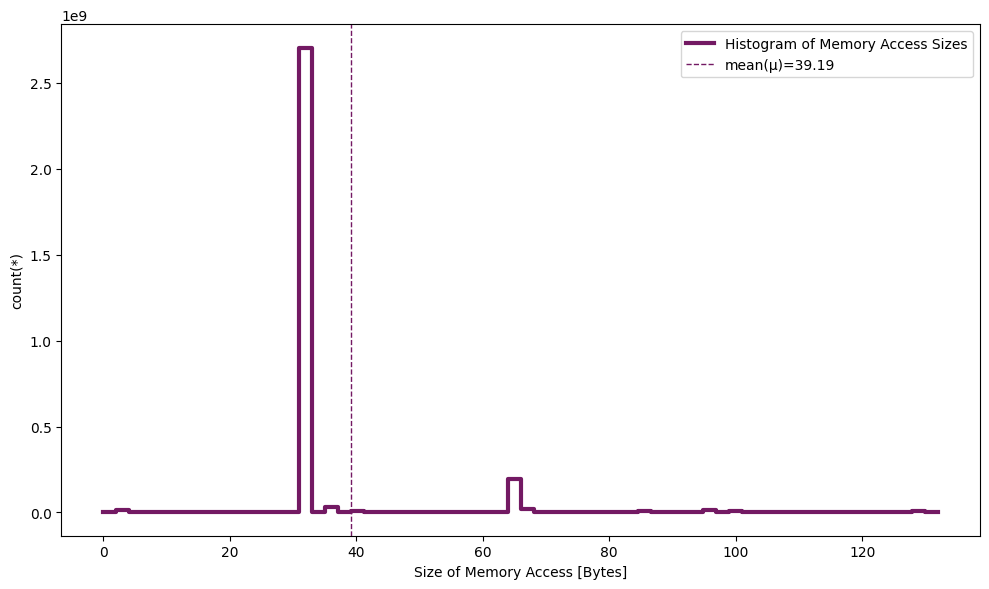

In [4]:
plt.figure(figsize=(10,6))
df.viz.histogram('memory_access_size', limits=[0,132], lw=3, shape=64, color=PRIMARY_COLOR, label="Histogram of Memory Access Sizes")
plt.xlabel('Size of Memory Access [Bytes]')
mean_size = df.memory_access_size.mean()
plt.axvline(mean_size, color=PRIMARY_COLOR, linewidth=1, linestyle='--', label=f"mean(μ)={mean_size:.2f}")
plt.legend()
plt.show()

#### Memory consumption by instruction

In [5]:
vaex.settings.display.max_rows = 30
opcode_range = df.groupby("opcode", agg={"memory_access_size": ["mean","max", "min"]}).sort(["memory_access_size_mean", "memory_access_size_max", "memory_access_size_min"],ascending=False).to_pandas_df()
opcode_range

,opcode,memory_access_size_mean,memory_access_size_max,memory_access_size_min
0,CREATE,1926.574551,26032,22
1,CREATE2,1625.956709,33324,15
2,EXTCODECOPY,639.792991,24086,2
3,CALLCODE,533.454545,2276,100
4,DELEGATECALL,216.463664,255556,1
5,CALLDATACOPY,206.609010,261120,1
6,LOG4,131.789590,19648,32
7,CALL,127.040576,267364,1
8,LOG1,96.243143,45344,32
9,CODECOPY,71.313883,460800,1


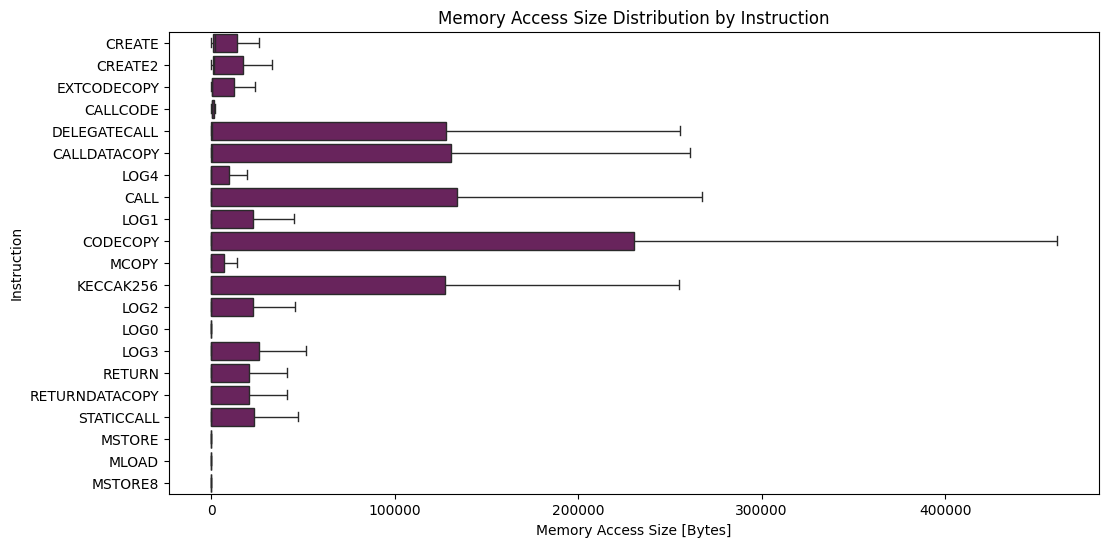

In [6]:
melted_opcode_range = opcode_range.melt(id_vars='opcode', 
                    value_vars=['memory_access_size_mean', 'memory_access_size_max', 'memory_access_size_min'],
                    var_name='memory_access_type', 
                    value_name='size')

plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_opcode_range, x='size', y='opcode', color=PRIMARY_COLOR)
plt.title('Memory Access Size Distribution by Instruction')
plt.xlabel('Memory Access Size [Bytes]')
plt.ylabel('Instruction')
plt.show()

### Memory Expansion

Across **100,000 blocks**, a total of **32.14 GiB** of memory was expanded. Upto **559,328 bytes** of was expanded, with an average of **11 bytes**. The `MSTORE`, `*CODECOPY`, and `*CALL` family of instructions expands the maximum amount of memory.

In [7]:
show_column_summary(df.memory_expansion)

,memory_expansion
data_type,int64
count,3054874863
NA,0
mean,11.295759129757846
std,120.06417
min,0
max,559328
25 percentile,0.0
50 percentile,0.0
75 percentile,0.0


#### Total memory expansion accross all blocks

In [8]:
df.memory_expansion.sum()

array(34507130624)

#### Distribution of memory expansion

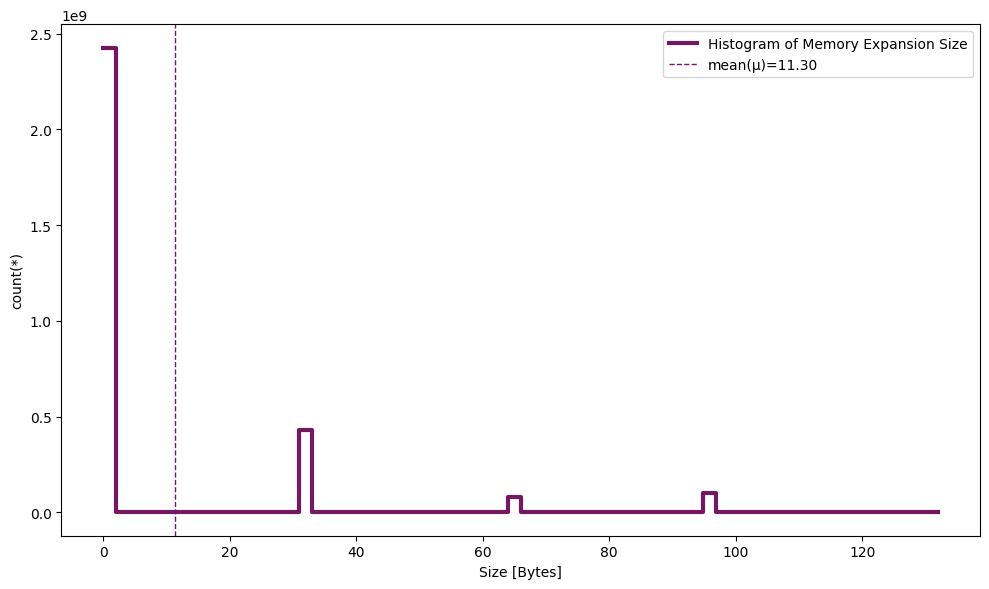

In [9]:
plt.figure(figsize=(10,6))
df.viz.histogram('memory_expansion', limits=[0,132], lw=3, shape=64, color=PRIMARY_COLOR, label="Histogram of Memory Expansion Size")
plt.xlabel('Size [Bytes]')
mean_expansion = df.memory_expansion.mean()
plt.axvline(mean_expansion, color=PRIMARY_COLOR, linewidth=1, linestyle='--', label=f"mean(μ)={mean_expansion:.2f}")
plt.legend()
plt.show()

In [10]:
expansion_by_opcode = df.groupby("opcode", agg={"memory_expansion": ["mean","max", "min"]}).sort(["memory_expansion_mean"],ascending=False).to_pandas_df()
expansion_by_opcode

,opcode,memory_expansion_mean,memory_expansion_max,memory_expansion_min
0,EXTCODECOPY,595.455583,24096,0
1,CALLDATACOPY,183.931063,261120,0
2,MCOPY,72.851950,13984,0
3,CODECOPY,49.438283,237696,0
4,MSTORE,19.406952,559328,0
5,STATICCALL,7.761295,25376,0
6,RETURNDATACOPY,6.310887,41152,0
7,CALL,2.482841,267104,0
8,DELEGATECALL,1.721607,4064,0
9,MSTORE8,0.968466,224,0


### Memory Offset

Half of all memory accesses occur at offsets of **4 words (128 bytes)** or less. The most frequently accessed offset is **64 bytes**, which is used by the Solidity memory pointer.

In [11]:
show_column_summary(df.memory_access_offset)

,memory_access_offset
data_type,int64
count,3054874863
NA,0
mean,1173.5257738346188
std,8566.401779
min,0
max,1502656
25 percentile,64.0
50 percentile,128.0
75 percentile,608.0


Offset distribution under 95 percentile.

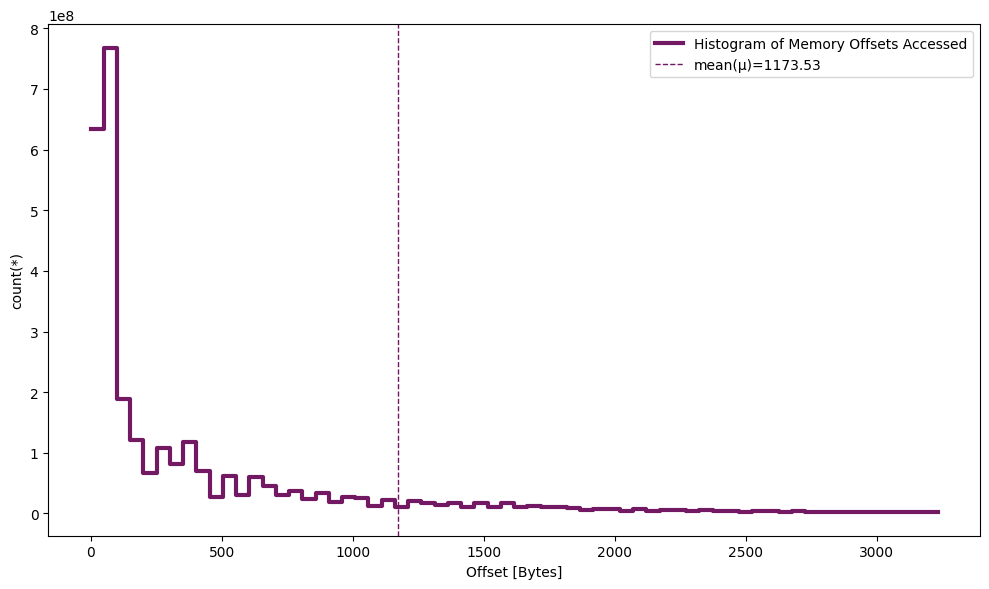

In [12]:
plt.figure(figsize=(10,6))
df.viz.histogram('memory_access_offset', limits=[0,3232], lw=3, shape=64, color=PRIMARY_COLOR, label="Histogram of Memory Offsets Accessed")
plt.xlabel('Offset [Bytes]')
mean_offset = df.memory_access_offset.mean()
plt.axvline(mean_offset, color=PRIMARY_COLOR, linewidth=1, linestyle='--', label=f"mean(μ)={mean_offset:.2f}")
plt.legend()
plt.show()

64 bytes is the most memory offset, which is consistent with its role as the offset for the [Solidity free memory pointer.](https://docs.soliditylang.org/en/latest/internals/layout_in_memory.html)

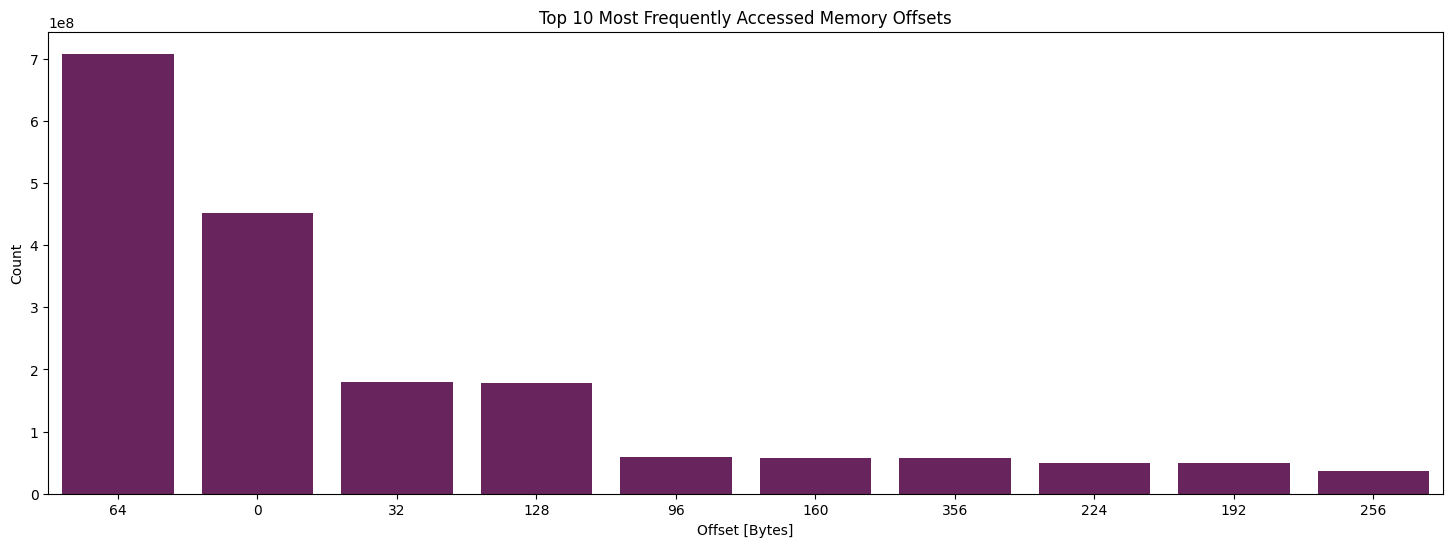

In [13]:
offset_value_counts = df.memory_access_offset.value_counts().head(10)
plt.figure(figsize=(18,6))
sns.barplot(x=offset_value_counts.index, y=offset_value_counts.values, color=PRIMARY_COLOR, order=offset_value_counts.index)
plt.xlabel('Offset [Bytes]')
plt.title("Top 10 Most Frequently Accessed Memory Offsets")
plt.ylabel('Count')
plt.show()

### Gas cost

A total of **80 trillion (80,513,608,146,590)** units of gas was expended on memory access, with an average gas cost of **26,355.8** per memory access. The `*CALL` family of instructions consumes the most gas due to their significant memory usage.

In [14]:
show_column_summary(df.opcode_gas_cost)

,opcode_gas_cost
data_type,int64
count,3054874863
NA,0
mean,26355.779453277722
std,384223.091959
min,0
max,29506566
25 percentile,3.0
50 percentile,3.0
75 percentile,6.0


In [15]:
df.opcode_gas_cost.sum()

array(80513608146590)

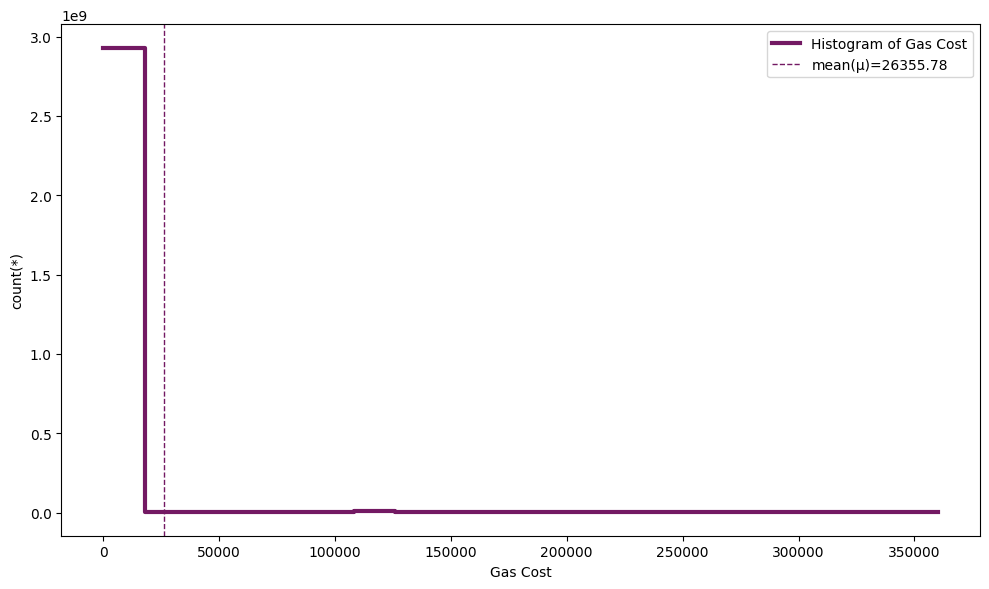

In [16]:
plt.figure(figsize=(10,6))
df.viz.histogram('opcode_gas_cost', limits=[0,360263], lw=3, shape=20, color=PRIMARY_COLOR, label="Histogram of Gas Cost", )
plt.xlabel('Gas Cost')
mean_gas_cost = df.opcode_gas_cost.mean()
plt.axvline(mean_gas_cost, color=PRIMARY_COLOR, linewidth=1, linestyle='--', label=f"mean(μ)={mean_gas_cost:.2f}")
plt.legend()
plt.show()

In [17]:
opcode_cost_range = df.groupby("opcode", agg={"opcode_gas_cost": ["mean","max", "min"]}).sort(["opcode_gas_cost_mean"],ascending=False).to_pandas_df()
opcode_cost_range

,opcode,opcode_gas_cost_mean,opcode_gas_cost_max,opcode_gas_cost_min
0,DELEGATECALL,1.871195e+06,29506566,100
1,CALL,5.404449e+05,29475557,100
2,STATICCALL,4.885388e+05,29222325,0
3,CALLCODE,4.035290e+05,1112150,100919
4,CREATE2,3.240937e+04,40336,32008
5,CREATE,3.212105e+04,33628,32002
6,LOG4,2.929317e+03,159059,2131
7,LOG3,1.931973e+03,414172,1756
8,LOG2,1.592378e+03,364901,1381
9,LOG1,1.519945e+03,363502,1006


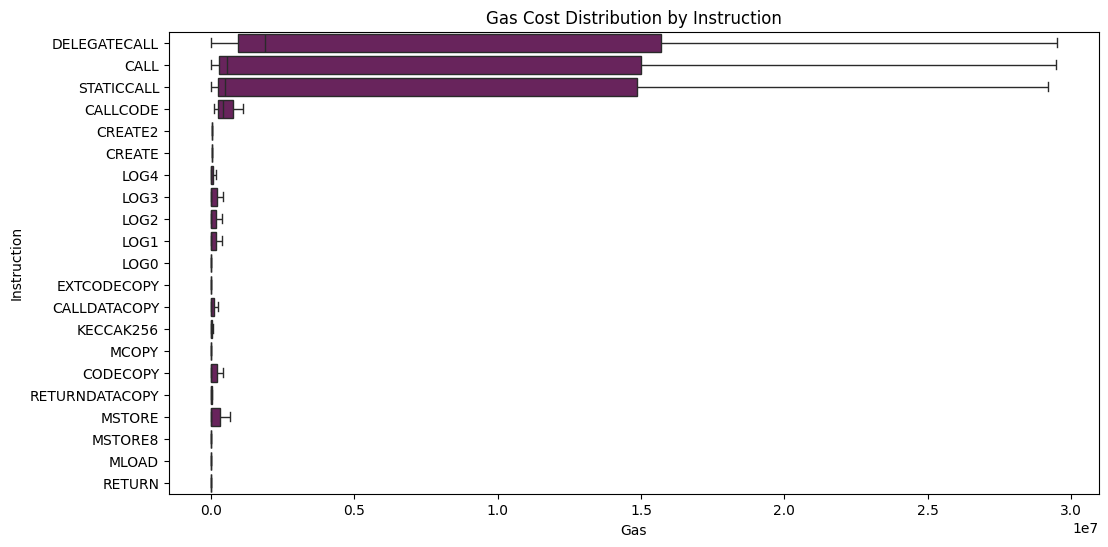

In [18]:
melted_opcode_cost_range = opcode_cost_range.melt(id_vars='opcode', 
                    value_vars=['opcode_gas_cost_mean', 'opcode_gas_cost_max', 'opcode_gas_cost_min'],
                    var_name='opcode_gas_cost_type', 
                    value_name='size')

plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_opcode_cost_range, x='size', y='opcode', color=PRIMARY_COLOR)
plt.title('Gas Cost Distribution by Instruction')
plt.xlabel('Gas')
plt.ylabel('Instruction')
plt.show()

### Instructions
The `MSTORE` and `MLOAD` instructions handle more than **83%** of memory accesses, `KECCAK256` follows at `6%`.

In [19]:
opcode_value_counts = df.opcode.value_counts()
relative_percentages = (opcode_value_counts / opcode_value_counts.sum()) * 100
pd.DataFrame({
    'Value': opcode_value_counts,
    'Relative Percentage': relative_percentages.map("{:f} %".format)
})

,Value,Relative Percentage
MSTORE,1439345207,47.116339 %
MLOAD,1117235088,36.572205 %
KECCAK256,205297450,6.720323 %
STATICCALL,70546854,2.309321 %
RETURN,63835239,2.089619 %
CALL,40778938,1.334881 %
LOG3,28285278,0.925906 %
CALLDATACOPY,26322536,0.861657 %
RETURNDATACOPY,19222067,0.629226 %
DELEGATECALL,12777107,0.418253 %


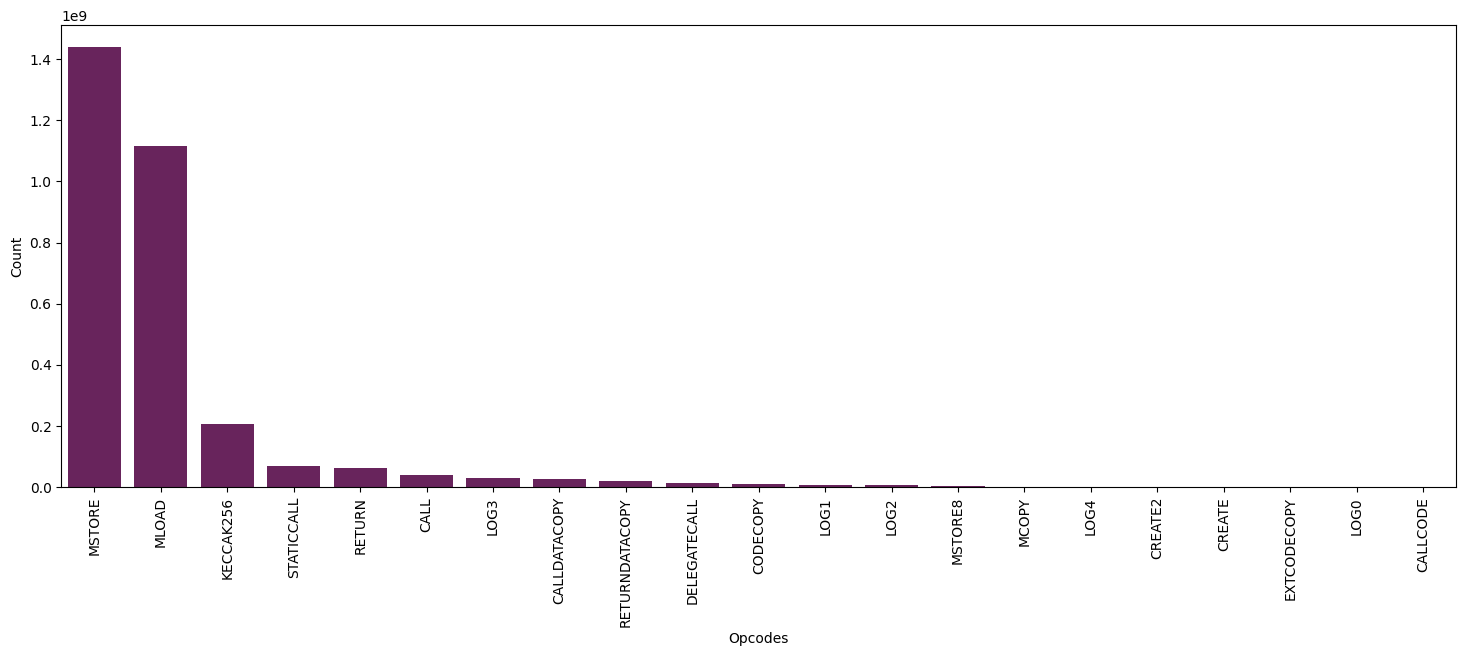

In [20]:
plt.figure(figsize=(18,6))
sns.barplot(x=opcode_value_counts.index, y=opcode_value_counts.values, color=PRIMARY_COLOR)
plt.xlabel('Opcodes')
plt.ylabel('Count')
plt.xticks(rotation='vertical')
plt.show()

### Call Depth
The dataset has an average call depth of **2.8**, with a 99th percentile of **9** call frames per transaction. Call depth influences memory expansion costs, as each call frame starts with an empty memory state.

In [21]:
df_call_frames = df.groupby(['transaction_id']).agg({'call_depth':vaex.agg.max('call_depth')})
show_column_summary(df_call_frames.call_depth)

,call_depth
data_type,int64
count,3054874863
NA,0
mean,2.887600998928381
std,1.797839
min,1
max,34
25 percentile,1.0
50 percentile,3.0
75 percentile,4.0


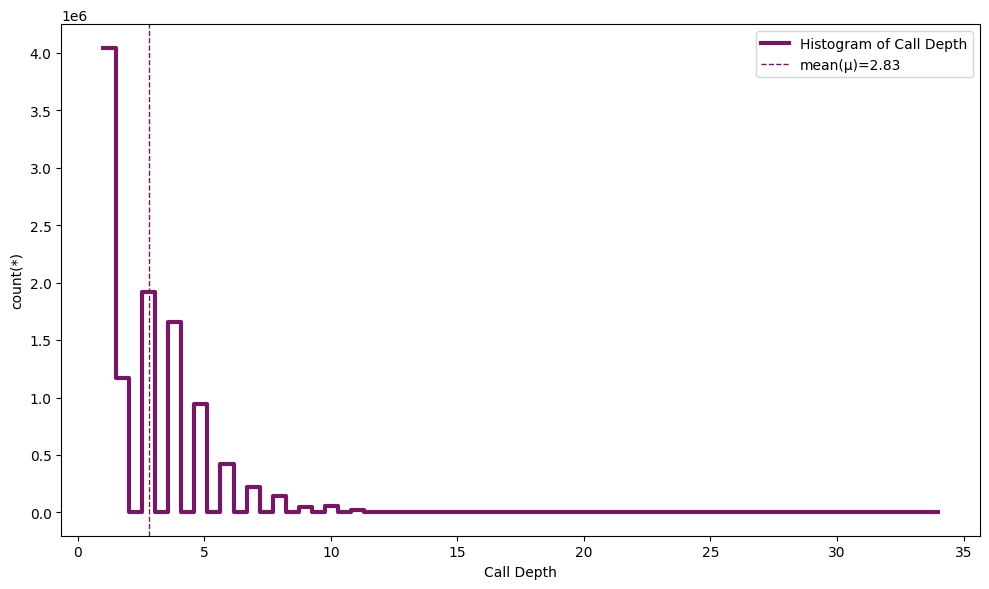

In [22]:
plt.figure(figsize=(10,6))
df_call_frames.viz.histogram('call_depth', limits="minmax", lw=3, shape=64, color=PRIMARY_COLOR, label="Histogram of Call Depth")
plt.xlabel('Call Depth')
mean_call_depth = df_call_frames.call_depth.mean()
plt.axvline(mean_call_depth, color=PRIMARY_COLOR, linewidth=1, linestyle='--', label=f"mean(μ)={mean_call_depth:.2f}")
plt.legend()
plt.show()

## References

- 📄 Gavin W., [Ethereum Yellow Paper](https://ethereum.github.io/yellowpaper/paper.pdf)
- 📄 EPF Wiki, [EVM](https://epf.wiki/#/wiki/EL/evm)
- 📄 Eth Research, [On Block Sizes, Gas Limits and Scalability](https://ethresear.ch/t/on-block-sizes-gas-limits-and-scalability/18444)
- 📄 John A., [Wait, It's All Resource Pricing?](https://www.youtube.com/watch?v=YoWMLoeQGeI)
- 📄 John A., [Induced Demand from Blockchain Resource Pricing](https://www.youtube.com/watch?v=_6ctMrlhcO4)
- 📄 Martin H., [Gas benchmarks](https://github.com/ethereum/benchmarking/blob/master/constantinople/analysis2.md)
- 📜 Ipsilon, [EVM benchmarks](https://github.com/ipsilon/evm-benchmarks)
- 📄 Ethereum Research, [Gas Price Table](https://ethresear.ch/t/gas-price-table/67)
- 📄 Ipsilon et al., [EVM384 Update 5: First Gas Cost Estimates](https://notes.ethereum.org/@poemm/evm384-update5#Memory-Manipulation-Cost)
- 📜 Geth, [Protocol Params](https://github.com/ethereum/go-ethereum/blob/master/params/protocol_params.go)
- 📄 Eth Research,[EIP-1380: Reduced gas cost for call to self](https://ethereum-magicians.org/t/eip-1380-reduced-gas-cost-for-call-to-self/1242)
- 📄 Michael K., [A Scalable Method to Analyze Gas Costs, Loops and Related Security Vulnerabilities on the Ethereum Virtual Machine](https://raw.githubusercontent.com/wiki/usyd-blockchain/vandal/pubs/MKong17.pdf)

## Appendix A: Memory-accessing Instructions

| **Instruction** | **Description**                                                                                                            |
|-----------------|----------------------------------------------------------------------------------------------------------------------------|
| KECCAK256       | Compute Keccak-256 hash.                                                                                                   |
| CALLDATACOPY    | Copy input data in current environment to memory.                                                                          |
| CODECOPY        | Copy code running in current environment to memory.                                                                        |
| MLOAD           | Load word from memory.                                                                                                     |
| MSTORE          | Save word to memory.                                                                                                       |
| MSTORE8         | Save byte to memory.                                                                                                       |
| EXTCODECOPY     | Copy an account’s code to memory.                                                                                          |
| RETURNDATACOPY  | Copy output data from the previous call to memory.                                                                         |
| MCOPY           | Duplicate data in memory.                                                                                                  |
| LOG0            | Append log record with no topics.                                                                                          |
| LOG1            | Append log record with one topic.                                                                                          |
| LOG2            | Append log record with two topics.                                                                                         |
| LOG3            | Append log record with three topics.                                                                                       |
| LOG4            | Append log record with four topics.                                                                                        |
| CREATE          | Create a new account with associated code.                                                                                 |
| CALL            | Message-call into an account.                                                                                              |
| CALLCODE        | Message-call into this account with an alternative account’s code.                                                         |
| RETURN          | Halt execution returning output data.                                                                                      |
| DELEGATECALL    | Message-call into this account with an alternative account’s code, but persisting the current values for sender and value. |
| CREATE2         | Create a new deterministic account with associated code.                                                                   |
| STATICCALL      | Static message-call into an account.                                                                                       |